## Predictions on COCO 2017 val set

In [1]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.3/915.3 kB 34.3 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO
model = YOLO("/kaggle/input/cv-detection/yolov8x.pt")
#save_json flag stores the predictions in standard COCO format
results = model.val(data="/kaggle/input/cv-detection/custom-coco.yaml", save_json=True, device='cuda:0')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.77 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8x summary (fused): 112 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs

Dataset '/kaggle/input/cv-detection/custom-coco.yaml' images not found ⚠️, missing path '/kaggle/working/datasets/coco/val2017.txt'


100%|██████████| 46.4M/46.4M [00:00<00:00, 110MB/s] 
Unzipping /kaggle/working/datasets/coco2017labels.zip to /kaggle/working/datasets/coco...: 100%|██████████| 122232/122232 [00:13<00:00, 8891.50file/s]


100%|██████████| 778M/778M [00:18<00:00, 44.8MB/s] 
Unzipping /kaggle/working/datasets/coco/images/val2017.zip to /kaggle/working/datasets/coco/images/val2017...: 100%|██████████| 5001/5001 [00:02<00:00, 2329.80file/s]

Dataset download success ✅ (37.3s), saved to /kaggle/working/datasets



100%|██████████| 755k/755k [00:00<00:00, 47.5MB/s]
val: Scanning /kaggle/working/datasets/coco/labels/val2017... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:04<00:00, 1086.80it/s]


val: New cache created: /kaggle/working/datasets/coco/labels/val2017.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [02:01<00:00,  2.58it/s]


                   all       5000      36335      0.736      0.648      0.707      0.542
                person       2693      10777      0.826       0.77      0.849      0.646
               bicycle        149        314       0.73      0.583      0.667      0.431
                   car        535       1918      0.757      0.684      0.754       0.54
            motorcycle        159        367      0.767      0.716       0.79       0.56
              airplane         97        143      0.833      0.874      0.928      0.791
                   bus        189        283       0.88      0.813      0.886      0.777
                 train        157        190      0.914      0.911      0.956      0.794
                 truck        250        414      0.683      0.572      0.652      0.491
                  boat        121        424      0.702      0.524      0.597       0.36
         traffic light        191        634       0.71      0.511      0.591      0.338
          fire hydran

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 19.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Saving runs/detect/val/predictions.json...

Evaluating pycocotools mAP using runs/detect/val/predictions.json and /kaggle/working/datasets/coco/annotations/instances_val2017.json...
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=39.66s).
Accumulating evaluation results...
DONE (t=8.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.589
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.50:0.

# Expected Calibration Error computation

In [1]:
!pip install pycocotools tqdm tidecv -q

In [2]:
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from tidecv import TIDE, datasets

from dataclasses import dataclass
from typing import List, Tuple, Dict, Set
from tqdm import tqdm
from collections import defaultdict

# Problem 1: Expected Calibration Error (ECE) 

ECE is a metric to evaluate the calibration of a model. It is defined as the expected value of the absolute difference between the accuracy and the confidence of the model. The confidence of the model is the probability assigned to the predicted class. The accuracy is 1 if the prediction is correct and 0 otherwise. The ECE is computed by dividing the confidence interval [0, 1] into M equally spaced bins and computing the weighted average of the absolute difference between the accuracy and the confidence in each bin. The weights are the proportion of samples in each bin. The ECE is defined as:

\begin{equation}
ECE = \sum_{m=1}^{M} \frac{B_m}{N} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
\end{equation}

where $B_m$ is the set of samples in bin $m$, $N$ is the total number of samples, $\text{acc}(B_m)$ is the accuracy of the model in bin $m$, and $\text{conf}(B_m)$ is the confidence of the model in bin $m$. The accuracy and confidence in bin $m$ are defined as:

\begin{equation}
\text{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbb{1} \left( y_i = \hat{y}_i \right)
\end{equation}

\begin{equation}
\text{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} p_i
\end{equation}

where $y_i$ is the true label of sample $i$, $\hat{y}_i$ is the predicted label of sample $i$, $p_i$ is the confidence of the model for sample $i$, and $\mathbb{1}(\cdot)$ is the indicator function.


## Starter Code

The following section contains some starter code to help you prepare the data using the COCO API. You can use this code to preprocess the data, or you can write your own code.

In [3]:
@dataclass
class Detection:
    bbox: np.ndarray  # [x1, y1, x2, y2]
    class_id: int
    confidence: float

@dataclass
class GroundTruth:
    bbox: np.ndarray  # [x1, y1, x2, y2]
    class_id: int

In [4]:
def coco_to_corners(bbox):
    """Convert COCO bbox [x,y,w,h] to corners format [x1,y1,x2,y2]"""
    return np.array([
        bbox[0],
        bbox[1],
        bbox[0] + bbox[2],
        bbox[1] + bbox[3]
    ])

def get_image_annotations(coco_gt, coco_dt, img_id, max_dets=100):
    """Get list of ground truth and detection annotations across all images"""
    gt_ids = coco_gt.getAnnIds(imgIds=img_id)
    gt_anns = coco_gt.loadAnns(gt_ids)
    gts = [
        GroundTruth(
            bbox=coco_to_corners(ann['bbox']),
            class_id=ann['category_id']
        )
        for ann in gt_anns
    ]

    # Get detections
    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dt_anns = coco_dt.loadAnns(dt_ids)
    if max_dets is not None:
        dt_anns = sorted(dt_anns, key=lambda x: x['score'], reverse=True)[:max_dets]
    dets = [
        Detection(
            bbox=coco_to_corners(ann['bbox']),
            class_id=ann['category_id'],
            confidence=ann['score']
        )
        for ann in dt_anns
    ]

    return gts, dets

def prepare_inputs(coco_gt, coco_dt, max_dets=100):
    """Convert COCO format to TIDE format for all images"""
    all_gts = []
    all_dets = []
    
    for img_id in tqdm(coco_gt.getImgIds(), desc="Processing images"):
        gts, dets = get_image_annotations(coco_gt, coco_dt, img_id, max_dets)
        all_gts.extend(gts)
        all_dets.extend(dets)
    
    return all_gts, all_dets

In [7]:
predictions_json = "/kaggle/input/cv-detection/coco_predictions.json" # Path to the predictions JSON file
ground_truth_json = "/kaggle/input/cv-detection/instances_val2017.json" # Path to the val annotations JSON file

coco_gt = COCO(ground_truth_json)       # Load ground truth annotations
coco_dt = coco_gt.loadRes(predictions_json) # Load predictions

loading annotations into memory...
Done (t=0.97s)
creating index...
index created!
Loading and preparing results...
DONE (t=4.05s)
creating index...
index created!


In [8]:
gts, dets = prepare_inputs(coco_gt, coco_dt, max_dets=100)
len(gts), len(dets)

Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 5070.64it/s]


(36781, 279040)

## Your task: implement code to compute the Expected Calibration Error.

## Solution

In [5]:
def compute_iou(box1, box2):
    """Implement the IOU computation between two bounding boxes.
    - This involves calculating the intersection and union areas of the boxes.
    - Returns the IOU score (intersection / union).
    """
    #finding coordinates of intersecting box if any???
    #top left corner
    xtop = max(box1[0], box2[0])
    ytop = max(box1[1], box2[1])
    #bottom right corner
    xbottom = min(box1[2], box2[2])
    ybottom = min(box1[3], box2[3])

    if xtop >= xbottom or ytop >= ybottom:
        return 0 #no area of intersection, so iou score is 0

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    intersection_area = (xbottom - xtop) * (ybottom - ytop)
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area #iou score

def compute_ece(dets, gts, M=10, iou_thresh=0.8):
    bins = np.linspace(0, 1, M+1) #creating M bins
    accs, confs, counts = np.zeros(M), np.zeros(M), np.zeros(M) #arrays to store data

    for det in dets:
        max_iou = 0
        for gt in gts:
            if det.class_id == gt.class_id:
                iou = compute_iou(det.bbox, gt.bbox)
                max_iou = max(iou, max_iou)

        bin_idx = np.digitize(det.confidence, bins, right=True)-1 #bin this conf value belongs to
        accs[bin_idx] += 1 if max_iou > iou_thresh else 0
        confs[bin_idx] += det.confidence
        counts[bin_idx] += 1

    ece = 0
    for i in range(M):
        if counts[i] > 0:
            acc = accs[i] / counts[i] #acc(Bm)
            conf = confs[i] / counts[i] #conf(Bm)
            ece += (counts[i] / len(dets)) * abs(acc - conf)
    return ece

In [15]:
ece = compute_ece(dets, gts)
print(ece)
print(f"ECE of COCO val2017 predictions by YOLOv8x: {ece:.4f}")

0.033040237026947784
ECE of COCO val2017 predictions by YOLOv8x: 0.0330


# Problem 2: Compute TIDE statistics.

## Solution

-- coco_predictions --

bbox AP @ [50-95]: 53.88
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      70.78    69.22    67.36    65.48    62.68    58.73    53.13    44.99    32.63    13.76  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     1.90     5.22     1.15     0.51     4.15     4.17  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP      16.97       8.77  



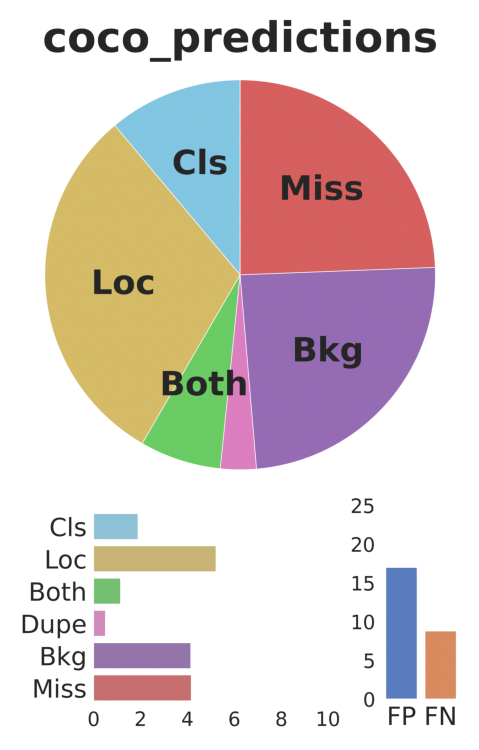

In [20]:
tide = TIDE()
tide.evaluate_range(datasets.COCO(), datasets.COCOResult("/kaggle/input/cv-detection/coco_predictions.json"), mode=TIDE.BOX)
tide.summarize()
tide.plot()

# Problem 3: size-based analysis.

## Starter Code: Spatial Grid data structure.


## Spatial Grid Implementation

The `SpatialGrid` class implements a spatial indexing data structure that helps efficiently find nearby objects. Using this data structure is useful for our size-based analysis as it significantly reduces the time complexity of finding overlapping boxes.

### How it works:
1. The image space is divided into a grid of cells. The size of the cells is defined by the `cell_size` parameter.
2. Each bounding box is mapped to the cells it overlaps.
3. When searching for nearby objects, we only need to check objects in the relevant grid cells.

### Usage Example:
```python
grid = SpatialGrid(cell_size=100)
grid.add_box(0, [100, 100, 200, 200])  # Add a box with index 0, and bbox coordinates [100, 100, 200, 200]
nearby = grid.get_nearby_indices([150, 150, 250, 250])  # Find boxes near the bbox [150, 150, 250, 250]
```

In [16]:
class SpatialGrid:
    def __init__(self, cell_size: int = 100):
        """A spatial indexing structure for efficient nearby object queries.
        
        This data structure divides 2D space into a grid and maintains a mapping of
        which objects overlap with each grid cell, enabling efficient spatial queries.
        """
        self.cell_size: int = cell_size
        # self.grid = defaultdict(list)
        self.grid: Dict[Tuple[int, int], List[int]] = defaultdict(list)
    
    def get_cell_coords(self, bbox: np.ndarray) -> Set[Tuple[int, int]]:
        """Get all grid cells that a bounding box overlaps with.
        
        Args:
            bbox: Bounding box coordinates [x1, y1, x2, y2]
                where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner

        Returns:
            Set of (x, y) grid cell coordinates
        """
        x1, y1, x2, y2 = bbox
        start_x = int(x1 // self.cell_size)
        end_x = int(x2 // self.cell_size)
        start_y = int(y1 // self.cell_size)
        end_y = int(y2 // self.cell_size)
        return {(i, j) for i in range(start_x, end_x + 1) 
                       for j in range(start_y, end_y + 1)}
    
    def add_box(self, idx: int, bbox: np.ndarray):
        """Add a bounding box to the spatial grid.
        
        Args:
            idx: Index of the bounding box
            bbox: Bounding box coordinates [x1, y1, x2, y2]
        """
        cells = self.get_cell_coords(bbox)
        for cell in cells:
            self.grid[cell].append(idx)
    
    def get_nearby_indices(self, bbox: np.ndarray) -> Set[int]:
        """Get indices of bounding boxes that are near the given bounding box.
        
        Args:
            bbox: Bounding box coordinates [x1, y1, x2, y2]
            
        Returns:
            Set of indices of nearby bounding boxes
        """
        cells = self.get_cell_coords(bbox)
        nearby = set()
        for cell in cells:
            nearby.update(self.grid[cell])
        return nearby

In [7]:
# Size thresholds as per COCO
SMALL_THRESH = 32 * 32
MEDIUM_THRESH = 96 * 96

## Your task: Implement the size-based ECE computation.

## Solution:

In [6]:
import json
with open("/kaggle/input/cv-detection/coco_predictions.json", 'r') as f:
    preds = json.load(f)

small_thresh = 36*36
medium_thresh = 96*96
small, medium, large = [], [], []

for pred in preds:
    area = pred['bbox'][2] * pred['bbox'][3]
    if area < small_thresh:
        small.append(pred)
    elif area < medium_thresh:
        medium.append(pred)
    else:
        large.append(pred)

#creating new jsons for each size category
with open("small_predictions.json", 'w') as f:
    json.dump(small, f)
with open("medium_predictions.json", 'w') as f:
    json.dump(medium, f)
with open("large_predictions.json", 'w') as f:
    json.dump(large, f)

In [16]:
def get_size_wise_ece(predictions_json, ground_truth_json="/kaggle/input/cv-detection/instances_val2017.json"):
    coco_gt = COCO(ground_truth_json)       # Load ground truth annotations
    coco_dt = coco_gt.loadRes(predictions_json) # Load predictions
    gts, dets = prepare_inputs(coco_gt, coco_dt, max_dets=100)
    print(len(gts), len(dets))
    ece = compute_ece(dets, gts)
    return ece

In [17]:
ece = get_size_wise_ece("small_predictions.json")
print(ece)
print(f"ECE of COCO val2017 small object predictions : {ece:.4f}")

loading annotations into memory...
Done (t=1.46s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.93s)
creating index...
index created!


Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 7584.40it/s]


36781 176115
0.01576995854981236
ECE of COCO val2017 small object predictions : 0.0158


In [18]:
ece = get_size_wise_ece("medium_predictions.json")
print(ece)
print(f"ECE of COCO val2017 medium object predictions : {ece:.4f}")

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.91s)
creating index...
index created!


Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 9135.78it/s]


36781 113180
0.018672455469163605
ECE of COCO val2017 medium object predictions : 0.0187


In [19]:
ece = get_size_wise_ece("large_predictions.json")
print(ece)
print(f"ECE of COCO val2017 large object predictions : {ece:.4f}")

loading annotations into memory...
Done (t=1.51s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!


Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 13140.24it/s]


36781 73809
0.11708592583560254
ECE of COCO val2017 large object predictions : 0.1171


# Size-based TIDE computation:

## Solution:

-- small_predictions --

bbox AP @ [50-95]: 9.47
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      15.15    14.37    13.63    12.80    11.58    10.04     8.10     5.67     2.76     0.60  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.51     4.48     0.26     0.12     3.29    24.12  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       9.16      41.22  



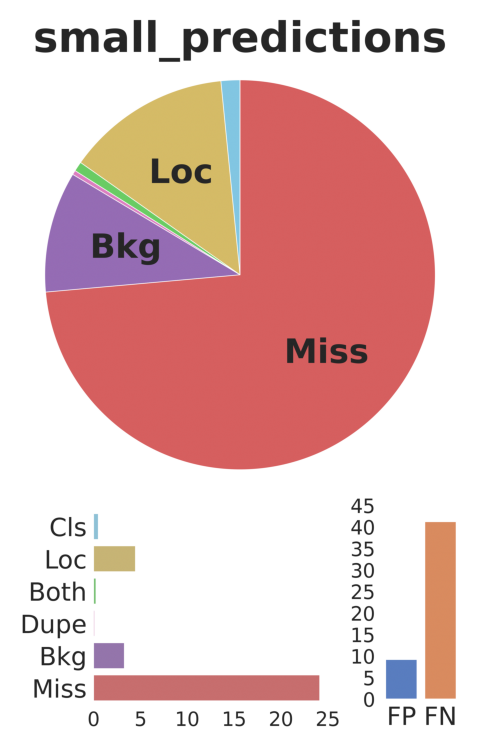

In [10]:
tide = TIDE()
tide.evaluate_range(datasets.COCO(), datasets.COCOResult("small_predictions.json"), mode=TIDE.BOX)
tide.summarize()
tide.plot()

-- medium_predictions --

bbox AP @ [50-95]: 17.33
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      24.24    23.47    22.45    21.68    20.56    19.20    17.12    13.89     8.64     2.11  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.62     6.93     0.49     0.18     1.92    29.93  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       8.40      49.17  



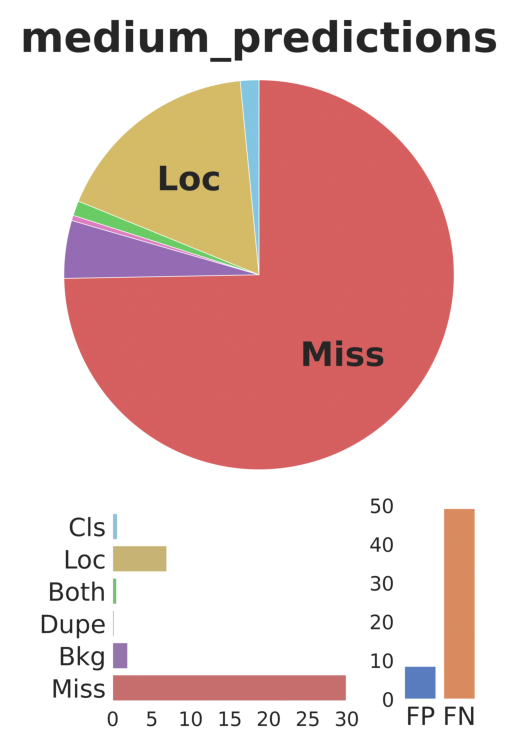

In [11]:
tide = TIDE()
tide.evaluate_range(datasets.COCO(), datasets.COCOResult("medium_predictions.json"), mode=TIDE.BOX)
tide.summarize()
tide.plot()

-- large_predictions --

bbox AP @ [50-95]: 28.64
                                         bbox AP @ [50-95]
  Thresh       50       55       60       65       70       75       80       85       90       95  
---------------------------------------------------------------------------------------------------
    AP      34.54    33.87    33.21    32.59    31.86    30.65    29.01    26.54    22.27    11.82  

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     0.88     4.10     0.54     0.25     0.44    37.99  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       5.09      50.86  



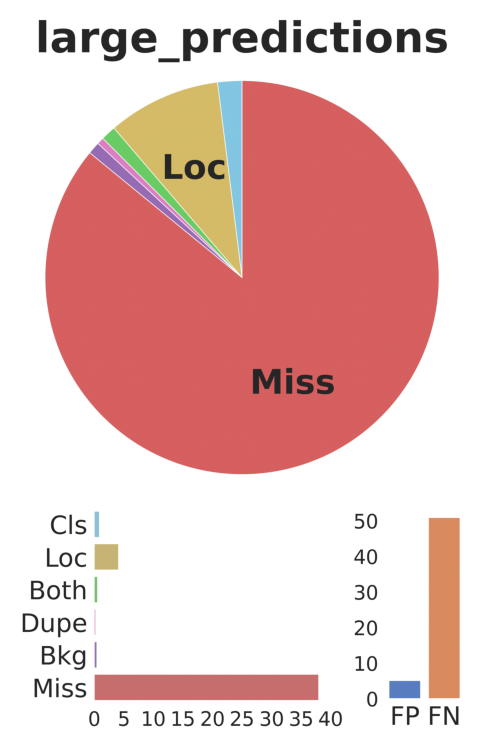

In [12]:
tide = TIDE()
tide.evaluate_range(datasets.COCO(), datasets.COCOResult("large_predictions.json"), mode=TIDE.BOX)
tide.summarize()
tide.plot()